In [1]:
import numpy as np
import statsmodels.tsa as tsa
from utils.utils import get_data_sub_paths

from matplotlib import rcParams
import os

os.environ['NUMEXPR_MAX_THREADS'] = str(os.cpu_count())
rcParams["font.family"] = "STIXGeneral"

From: [Machine Learning Mastery: How to Create an ARIMA Model for Time Series Forecasting in Python
](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)

- **AR**: Autoregression. A model that uses the dependent relationship between an observation and some number of lagged observations.
- **I**: Integrated. The use of differencing of raw observations (e.g. subtracting an observation from an observation at the previous time step) in order to make the time series stationary.
- **MA**: Moving Average. A model that uses the dependency between an observation and a residual error from a moving average model applied to lagged observations.



The parameters of the ARIMA model are defined as follows:

- **p**: The number of lag observations included in the model, also called the lag order.
- **d**: The number of times that the raw observations are differenced, also called the degree of differencing.
- **q**: The size of the moving average window, also called the order of moving average.

In [2]:
from statsmodels.tsa.stattools import pacf, acf
from utils.plots import plot, plot_autocorr
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from utils.mutual_information_plots import plot_mi_curves
from statsmodels.tsa.arima_model import ARIMA
from utils.utils import load_total_counts, to_title, set_system_seed
from utils.plots import plot_time_signals, plot, plot_autocorr
import scipy as sp
import seaborn as sns
from utils.plots import plot_corr
from utils.display import dmat

In [3]:
data_sub_paths = [i for i in get_data_sub_paths() if i.startswith('Totals')]
data_sub_paths

['Totals_T24H_2001-01-01_2019-01-02_LAT41.641_42.024_LON-87.821_-87.525',
 'Totals_T168H_2001-01-04_2019-01-10_LAT41.641_42.024_LON-87.821_-87.525',
 'Totals_T1H_2014-01-01_2019-01-01_LAT41.641_42.024_LON-87.821_-87.525']

In [4]:
data_sub_path = data_sub_paths[0]
save_folder = f"./data/processed/{data_sub_path}/plots/"
os.makedirs(save_folder, exist_ok=True)
FREQ = data_sub_path.lstrip('Totals_T').split('_')[0]
time_steps_per_day = 24/int(FREQ[:-1])

freq_title = {
    "24H":"Daily",
    "1H": "Hourly",
    "168H":"Weekly",
}.get(FREQ, "Hourly")
print(f"Using: {freq_title} ({FREQ})")

df = load_total_counts(folder_name=data_sub_path)
df['TOTAL'] = df.sum(axis=1)
df = df.reindex(columns=np.roll(df.columns, 1))
df.columns = to_title(df.columns)
display(df)

Using: Daily (24H)


Total  Theft  Battery  Criminal Damage  Narcotics  Assault  \
2001-01-01   1253    400      292              232         96       70   
2001-01-02    884    218      142              118        175       65   
2001-01-03    910    222      163              136        133       79   
2001-01-04    939    241      172              132        142       57   
2001-01-05   1020    260      177              138        185       67   
...           ...    ...      ...              ...        ...      ...   
2018-12-27    469    157       90               65         26       43   
2018-12-28    547    177      114               62         53       46   
2018-12-29    535    132      139               83         38       50   
2018-12-30    530    133      134               83         32       47   
2018-12-31    506    153      105               93         21       41   

            Burglary  Motor Vehicle Theft  Robbery  
2001-01-01        65                   58       40  
2001-01-02        68                   64       34  
2001-01-03        57                   69       51  
2001-01-04        53                   87       55  
2001-01-05        55                   83       55  
...              ...                  ...      ...  
2018-12-27        33                   28       27  
2018-12-28        32                   25       38  
2018-12-29        35                   28       30  
2018-12-30        31                   32       38  
2018-12-31        29                   25       39  

[6574 rows x 9 columns]

In [5]:
def generate_mock_sequence(n=1000,period=7,lags=()):
    period = 7
    n = 1000
    baseline = sp.stats.poisson.rvs(.5*np.ones(n))
    seasonal = sp.stats.poisson.rvs((period-np.arange(n)%period)/period)*3

    data = baseline + seasonal 
    for lag in lags:
        data += sp.stats.poisson.rvs(np.roll(baseline,-1*lag))
        
    return data

In [6]:
from utils.rolling import rolling_norm

window, period = {
    "24H": (10,7),  # jumps in weeks
    "1H":  (10,24),  # jumps in days
    "168H": (10,1),  # jumps in weeks
}.get(FREQ, (10,1))

normed_df = rolling_norm(
    data=df,
    window=window,
    period=period,
    center=False,
    fill=np.nan,
    axis=0,
    mode=None,
).dropna()
normed_df

Total     Theft   Battery  Criminal Damage  Narcotics  \
2001-03-05 -0.060671  0.239053 -0.839360        -0.123021   1.279051   
2001-03-06  0.119416 -0.749707  0.905753        -0.169660  -0.304801   
2001-03-07  2.368946  1.300064  2.301654         1.953214   1.164256   
2001-03-08  0.651101 -0.046529  1.476487         0.399600  -0.593304   
2001-03-09  1.666004  1.168854  1.391823         0.510600  -0.733085   
...              ...       ...       ...              ...        ...   
2018-12-27 -1.054179 -0.629690 -1.391087        -0.109845  -0.349215   
2018-12-28 -1.188686 -0.610109 -1.214029        -1.009026   1.239825   
2018-12-29 -0.682720 -2.168370  0.106813         0.362905   0.823223   
2018-12-30  0.091233 -0.733831 -1.159052         1.020106   0.667837   
2018-12-31 -0.068045 -0.496224 -0.603487         1.587158  -1.004073   

             Assault  Burglary  Motor Vehicle Theft   Robbery  
2001-03-05 -0.709883 -1.390542            -0.772988 -1.930186  
2001-03-06  1.593132 -1.540094             0.049447  0.108257  
2001-03-07  1.857858 -1.525260             2.078829  0.024853  
2001-03-08  0.837888  1.686442             0.390778 -0.844461  
2001-03-09  1.422562  0.516016             0.600284  1.495224  
...              ...       ...                  ...       ...  
2018-12-27 -1.329580  0.168073             0.190117  0.800198  
2018-12-28 -0.637104 -0.447584            -0.784881  1.440195  
2018-12-29 -0.062137  1.254963            -0.213399  0.057939  
2018-12-30  0.022651  1.411695             0.849232  2.341951  
2018-12-31 -1.237153 -0.667486            -0.019213  2.117667  

[6511 rows x 9 columns]

In [7]:
from utils.plots import plot_time_signals

plot_time_signals(t_range=normed_df.index, **normed_df[['Total']]).show()
plot_time_signals(t_range=df.index, **df[['Total']]).show()

In [8]:
def pairplot(df):
    sns.pairplot(df)
    plt.show()

In [9]:
if FREQ == "1H":
    df['Hour'] = df.index.hour
df['DayOfWeek'] = df.index.dayofweek
df['Day'] = df.index.day
df['Month'] = df.index.month

import pingouin as pg
def partial_correlation(data,x,y,covar=None):
    return pg.partial_corr(data=df, x=x, y=y, covar=covar)

display(partial_correlation(df,'Assault','Theft', 'DayOfWeek'))
display(partial_correlation(df,'Assault','Theft'))

n         r         CI95%        r2    adj_r2  p-val BF10  power
pearson  6574  0.693254  [0.68, 0.71]  0.480602  0.480444    0.0  inf    1.0

n         r         CI95%        r2    adj_r2  p-val BF10  power
pearson  6574  0.697605  [0.68, 0.71]  0.486653  0.486497    0.0  inf    1.0

In [18]:
from IPython.display import Latex, display


def bmatrix(a):
    """Returns a LaTeX bmatrix

    :a: numpy array
    :returns: LaTeX bmatrix as a string
    """
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv += [r'\end{bmatrix}']
    return '\n'.join(rv)


def dmat(a):
    display(Latex(bmatrix(a)))


In [110]:
x = np.array([2,4,15,20])
y = np.array([1,2,3,4])
z = np.array([0,0,1,1])

xyz = pd.DataFrame({'x':x,'y':y,'z':z,})

In [41]:
# prof mentioneed that the inverse of the correlation matrix can lead to the partial correlation

x = np.random.randn(n)
y = np.random.randn(n)
z = np.random.randint(1,10,n)
mask = z % 2 == 0
y[mask] = (x[mask] + np.random.randn(len(x[mask])))/2

xyz = pd.DataFrame({'x':x,'y':y,'z':z,})

n         r         CI95%        r2    adj_r2         p-val  \
pearson  1000  0.278758  [0.22, 0.33]  0.077706  0.075856  2.641095e-19   

              BF10  power  
pearson  1.239e+16    1.0

In [117]:
import statsmodels.api as sm

res_xz = sm.OLS(x.reshape(-1,1),z).fit().resid
res_yz = sm.OLS(y.reshape(-1,1),z).fit().resid
np.cor

In [116]:
from sklearn.linear_model import LinearRegression

res_xz = z - LinearRegression().fit(x.reshape(-1,1),z).predict(x.reshape(-1,1))
res_yz = z - LinearRegression().fit(y.reshape(-1,1),z).predict(y.reshape(-1,1))

np.corrcoef(res_xz,res_yz),np.corrcoef(y,x)

(array([[1.        , 0.90873893],
        [0.90873893, 1.        ]]),
 array([[1.        , 0.96950155],
        [0.96950155, 1.        ]]))

In [102]:
(len(x[~mask])*0.008 + len(x[mask])*0.72)/len(mask)

0.34264

In [104]:
pg.partial_corr(data=xyz[mask], x='x', y='y', covar=['z'])

n         r         CI95%       r2    adj_r2         p-val  \
pearson  470  0.726588  [0.68, 0.77]  0.52793  0.525909  2.641793e-78   

              BF10  power  
pearson  5.255e+74    1.0

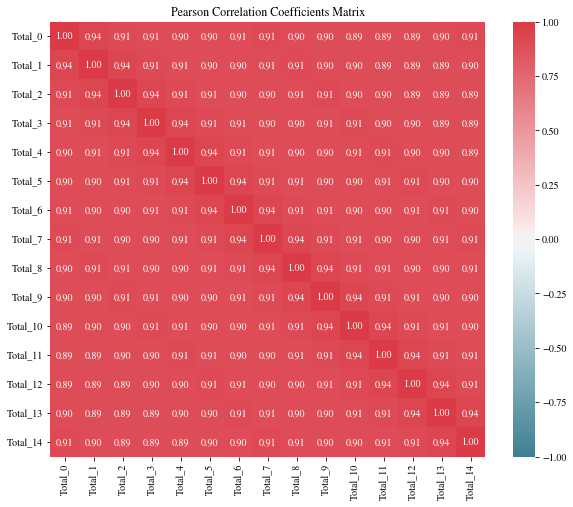

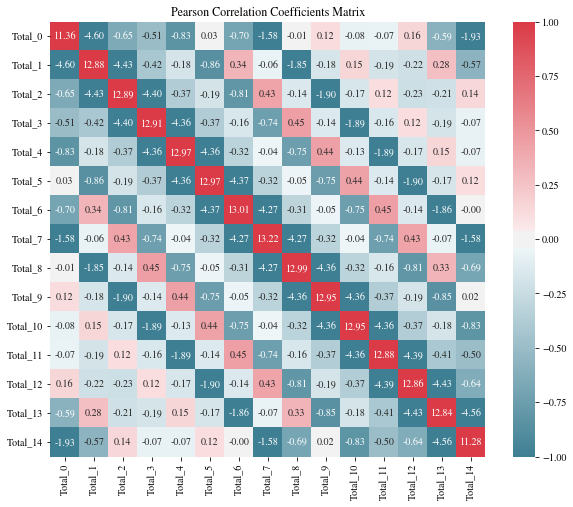

In [55]:
def lag_series(series, lag):
    name = series.name
    return pd.DataFrame({
        f"{name}_{i}": series[lag-i:-lag-i].values
        for i in range(0,lag+1)
    })

corr = lag_series(df.Total, 14).corr()
plot_corr(corr)
plt.show()

info_mat = np.linalg.inv(corr)
info_mat = pd.DataFrame(info_mat, columns=corr.columns, index=corr.index)
plot_corr(info_mat)
plt.show()

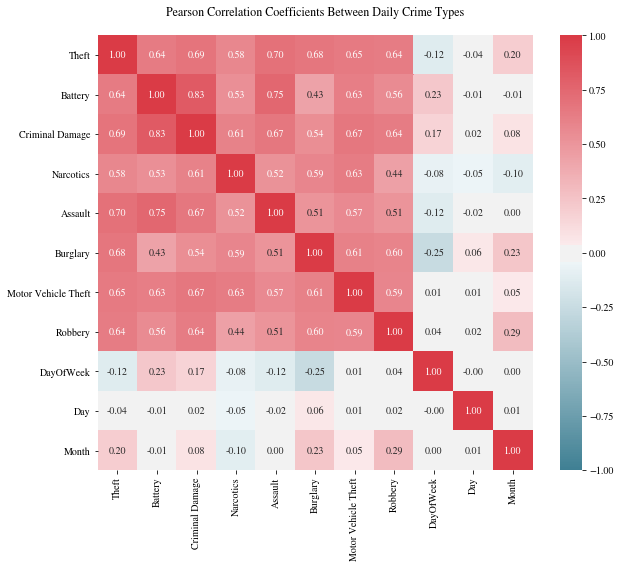

In [24]:
corr = df.loc[:, df.columns != 'Total'].corr()
plot_corr(corr, title=f'Pearson Correlation Coefficients Between {freq_title} Crime Types\n')
plt.show()

In [223]:
max_offset = {
    "24H": 400,  # year in days
    "1H":  200,  # week in hours
    "168H": 55,  # year in weeks
}.get(FREQ, 50)

print(f"using period and window: {period, window}")

data = df.Total
data = rolling_norm(data, window=10, period=7).dropna()
data = rolling_norm(data, window=10, period=365).dropna()


# data = np.log2(df.Total + 1)

plot_time_signals(t_range=data.index,data=data).show()
plot_autocorr(data=data, partial=False,max_offset=max_offset).show()
plot_autocorr(data=data, partial=True,max_offset=max_offset).show()
plot_mi_curves(
    a=data.values,
    t_range=data.index,
    max_offset=max_offset,
    norm=True,
    log_norm=False,
    bins=10,
    month_divisions=10,
    year_divisions=12,
    temporal_variables=(
#         'Hour',
#         'Day of Week',
#         'Time of Month',
        'Time of Year',
    ),
).show()

using period and window: (7, 10)


count    3226.000000
mean        4.719777
std         1.909477
min         0.000000
25%         3.000000
50%         5.000000
75%         6.000000
max         9.000000
dtype: float64



In [12]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [13]:
sar = SARIMAX(endog=data,order=(4,1,1),seasonal_order=(0, 0, 0, 7))
model_fit = sar.fit()
display(model_fit.summary())
forecast = model_fit.forecast(steps=1)
forecast

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Total   No. Observations:                43608
Model:               SARIMAX(4, 1, 1)   Log Likelihood              -59318.282
Date:                Tue, 12 Jan 2021   AIC                         118648.564
Time:                        11:31:41   BIC                         118700.662
Sample:                    01-10-2014   HQIC                        118664.988
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2065      0.005     44.017      0.000       0.197       0.216
ar.L2          0.1367      0.005     28.542      0.000       0.127       0.146
ar.L3          0.0746      0.005     15.512      0.000       0.065       0.084
ar.L4          0.0271      0.005      5.712      0.000       0.018       0.036
ma.L1         -1.0000      0.000  -2297.830      0.000      -1.001      -0.999
sigma2         0.8891      0.007    131.710      0.000       0.876       0.902
===================================================================================
Ljung-Box (Q):                      511.54   Jarque-Bera (JB):               428.95
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               1.03   Skew:                             0.19
Prob(H) (two-sided):                  0.07   Kurtosis:                         2.69
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

2019-01-01    0.545028
Freq: H, dtype: float64

In [14]:
ar = ARIMA(data,order=(4,0,1))
model_fit = ar.fit()
display(model_fit.summary())
output = model_fit.forecast(steps=1)
forecast, stderr, conf_int = output
forecast

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:                  Total   No. Observations:                43608
Model:                     ARMA(4, 1)   Log Likelihood              -59312.690
Method:                       css-mle   S.D. of innovations              0.943
Date:                Tue, 12 Jan 2021   AIC                         118639.380
Time:                        11:31:54   BIC                         118700.161
Sample:                    01-10-2014   HQIC                        118658.541
                         - 12-31-2018                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           0.0033      0.008      0.408      0.683      -0.013       0.019
ar.L1.Total     0.4317      0.114      3.803      0.000       0.209       0.654
ar.L2.Total     0.0895      0.024      3.713      0.000       0.042       0.137
ar.L3.Total     0.0428      0.017      2.576      0.010       0.010       0.075
ar.L4.Total     0.0097      0.011      0.886      0.376      -0.012       0.031
ma.L1.Total    -0.2255      0.113     -1.987      0.047      -0.448      -0.003
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.4615           -0.0000j            1.4615           -0.0000
AR.2           -0.3893           -3.7015j            3.7219           -0.2667
AR.3           -0.3893           +3.7015j            3.7219            0.2667
AR.4           -5.0945           -0.0000j            5.0945           -0.5000
MA.1            4.4349           +0.0000j            4.4349            0.0000
-----------------------------------------------------------------------------
"""

array([0.53920141])

In [15]:
pd.DataFrame(result.resid).plot(kind='kde')
plt.show()

NameError: name 'result' is not defined

In [ ]:
n = 1000
ndiff = 1

data = np.random.randn(n)/2
for i in range(ndiff):
    data = np.cumsum(data)
diffs = {}
for i in range(1,ndiff+1):
    diffs[f'diff{i}'] = np.diff(a=data,n=i)
plot(data=data,**diffs).show()


In [150]:
def principal_sub(matrix,order):
    return matrix[:order,:order]


def principal_minor(matrix,order):
    return np.linalg.det(principal_sub(matrix,order))

def is_pos_semi_def(matrix):
    if (matrix.T == matrix).all() is False:
        return False
    
    for i in range(1,len(matrix)+1):
        det = principal_minor(matrix=matrix, order=i)
        if det < 0:
            print(f"principal minor {i} is {det}; not greater than or equal 0.")
            return False
    return True

In [ ]:
import plotly.graph_objects as go


ndims = 3
nsamples = 1000
mean = np.zeros(ndims)

a = np.random.randn(ndims,ndims)
corr = np.dot(a.T,a)

var = np.eye(ndims)*np.arange(1,ndims+1)
cov = np.dot(np.dot(var,corr),var)
dmat(cov)

print(f"is_pos_semi_def => {is_pos_semi_def(cov)}")
samples = np.random.multivariate_normal(mean,cov, size=nsamples)
samples = samples**1

go.Figure(
    data=[
        go.Scatter3d(x=samples[:,0],y=samples[:,1],z=samples[:,2], mode='markers', opacity=0.1),
#         go.Scatter(x=samples[:,0],y=samples[:,1], mode='markers', opacity=0.5),
    ],
    layout=dict(
        height=600,
        width=600,
    ),
).show()

In [154]:
import scipy as sp

In [155]:
pcorrs = np.zeros(nlags)
for lag in range(1,nlags):
    pcorrs[lag] = sp.stats.pearsonr(y[:-lag],y[lag:])[0]
    
plot(pcorrspcorrs=pcorrs)

NameError: name 'nlags' is not defined

### Mock data

In [156]:
from utils.data_processing import sequencify, batchify

n = 5_000
period = 24
nlags = 3*period + 1

data = np.cos(2*np.pi*(np.arange(n)/period))*100
data = sp.stats.norm.rvs(data, scale=.1*np.max(data))

mock_data = sequencify(a=data,seq_len=nlags+1)


X, y = mock_data[:,:-1], mock_data[:,-1]
from sklearn.linear_model import LinearRegression, ARDRegression

ardr = ARDRegression()
ardr.fit(X=X,y=y)

lr = LinearRegression()
lr.fit(X=X,y=y)

x_coeff = np.arange(1,X.shape[1]+1)
go.Figure(
    data=[
        go.Scatter(x=x_coeff,y=lr.coef_,name='LR',opacity=.5),
        go.Scatter(x=x_coeff,y=ardr.coef_,name='ARDR',opacity=.5),
    ],
).show()

# ar:
plot(data=data).show()
plot_autocorr(data=data,max_offset=nlags, partial=True).show()
plot_autocorr(data=data,max_offset=nlags, partial=False).show()

/home/bernard/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning:

invalid value encountered in sqrt



In [2]:
import pandas as pd

In [3]:
from scipy.ndimage import gaussian_filter1d
from sklearn.metrics import mean_absolute_error
from utils.data_processing import auto_corr
from utils.filters import GaussianFilter1D

In [4]:
from utils.utils import load_total_counts
from utils.data_processing import normalize_df
from utils.plots import plot

folder_names = [i for i in get_data_sub_paths() if i.startswith('Tota')]
print(folder_names)

df = load_total_counts(folder_names[0])
df['TOTAL'] = df.sum(axis=1)
df = normalize_df(df)

['Totals_T24H_2001-01-01_2019-01-01_LAT41.645_42.022_LON-87.934_-87.525']


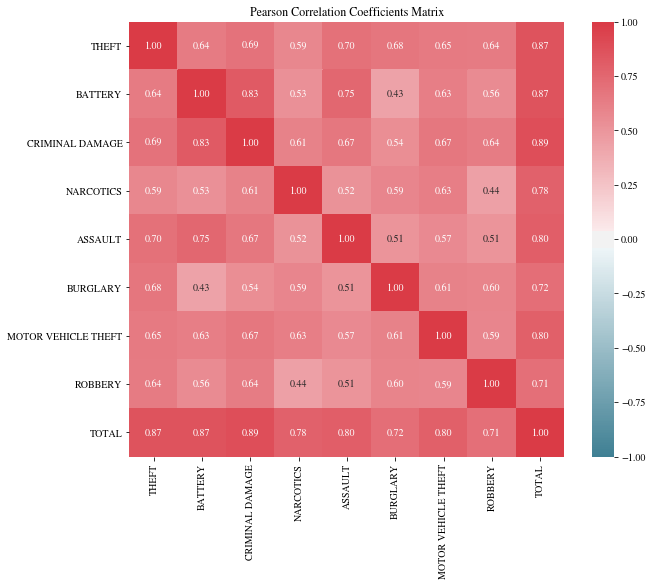

In [5]:
from utils.plots import plot_corr
plot_corr(df.corr())

In [11]:
# plot(**{col.title(): df[col] for col in df.columns})
a = df.TOTAL

f1d = GaussianFilter1D(sigma=3)
# f1d.fit(a)
b = f1d.transform(a)
plot(a=a,b=b)

In [60]:
np.abs(d.values) > 3 

array([ True, False, False, ..., False, False,  True])

In [65]:
import plotly.express as px
d = (b-a)
d = d - d.mean()
d = d/d.std()

outliers = pd.DataFrame({
    "Outlier": np.abs(d.values) > 2,
    "Residuals": d.values,
}, index=d.index)

fig = px.scatter(outliers,y='Residuals',color='Outlier',marginal_y='histogram')
fig.update_layout(
    font=dict(family="STIXGeneral"),
    title='Residuals over Time',
    title_x=0.5,
    yaxis_title='Residuals',
    xaxis_title='Date',
)

In [19]:
from statsmodels.tsa.arima_model import ARIMA
 
model = ARIMA(df.TOTAL, order=(5,1,0), freq=)
model_fit = model.fit(disp=0)

/home/bernard/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/home/bernard/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



In [33]:
df.TOTAL.index

DatetimeIndex(['2001-01-01', '2001-01-02', '2001-01-03', '2001-01-04',
               '2001-01-05', '2001-01-06', '2001-01-07', '2001-01-08',
               '2001-01-09', '2001-01-10',
               ...
               '2018-12-22', '2018-12-23', '2018-12-24', '2018-12-25',
               '2018-12-26', '2018-12-27', '2018-12-28', '2018-12-29',
               '2018-12-30', '2018-12-31'],
              dtype='datetime64[ns]', length=6574, freq=None)